In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.metrics import average_precision_score
from datasets import load_dataset, Audio
from timm.optim import Mars
from fastprogress import master_bar, progress_bar
from torchvision.transforms.v2 import RandomCrop, CenterCrop, CutMix, MixUp
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('high')
device="cuda:0"
dataset = load_dataset("danjacobellis/speech_commands_v2").cast_column('opus', Audio(decode=False))

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset['train'].num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/128)*6e-4
config.min_lr = config.max_lr/100
config.plot_update = 128
config.epochs = 200
config.lr_scale = 10
config.lr_offset = 0.25
config.lr_pow = 2
config.weight_decay = 0.
config.num_workers = 24
config.audio_len = 256*216
config.crop_size = 256*256

# model config
config.channels = 1
config.J = 8
config.embed_dim = 256
config.dim_head = 32
config.exp_ratio = 4.0
config.classifier_num_classes = 35

In [4]:
from pytorch_wavelets import DWT1DForward
from tft.transforms import WPT1D
from tft.models import TFTClassifier1D

wt = DWT1DForward(J=1, mode='periodization', wave='bior4.4')
wpt = WPT1D(wt,J=config.J).to(device)

model = TFTClassifier1D(config,wpt).to(device)

for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

0.0 	 wpt
11.574528 	 ascan
0.328448 	 pool
0.008995 	 classifier


In [5]:
mix_transforms = [
    CutMix(num_classes=config.classifier_num_classes, alpha=1.),
    MixUp(num_classes=config.classifier_num_classes, alpha=1.)
]
rand_crop = RandomCrop(
    size=(1,config.crop_size),
    pad_if_needed=True,
)

cent_crop = CenterCrop(
    size=(1,config.crop_size),
)

def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, 1, config.crop_size), dtype=torch.float)
    y = []
    for i_sample, sample in enumerate(batch):
        y.append(sample['label'])
        x_raw, fs = torchaudio.load(uri = sample['opus']['bytes'],normalize=False)
        x[i_sample,:,:,:] = rand_crop(x_raw.unsqueeze(0).unsqueeze(0))
    return x[:,:,0,:], y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, 1, config.crop_size), dtype=torch.float)
    y = []
    for i_sample, sample in enumerate(batch):
        y.append(sample['label'])
        x_raw, fs = torchaudio.load(uri = sample['opus']['bytes'],normalize=False)
        x[i_sample,:,:,:] = cent_crop(x_raw.unsqueeze(0).unsqueeze(0))
    return x[:,:,0,:], y

In [6]:
optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

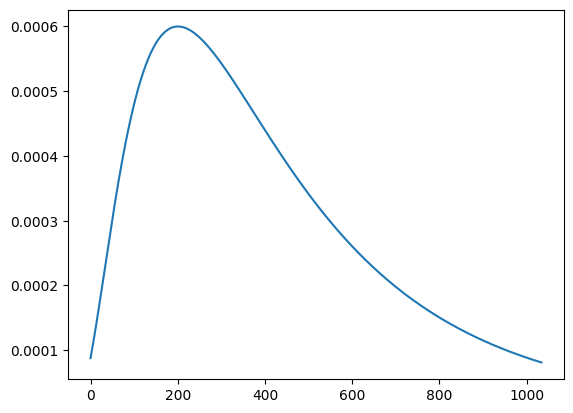

In [52]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.plot(learning_rates)

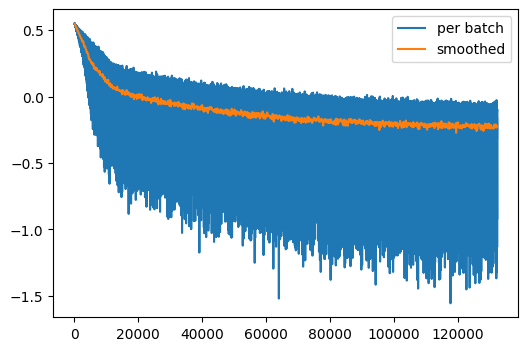

In [7]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset['train'],
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        x = x.unsqueeze(1).to(device)
        y = torch.tensor(y).to(torch.long).to(device)
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y)
        x = x[:,0]
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset['validation'],
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        x = x.to(device)
        y = torch.tensor(y).to(torch.long).to(device)
        with torch.no_grad():
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= dataset['validation'].num_rows
    mb.main_bar.comment = f'validation accuracy {valid_acc[i_epoch]:.4g}'

    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

(0.9, 1.0)

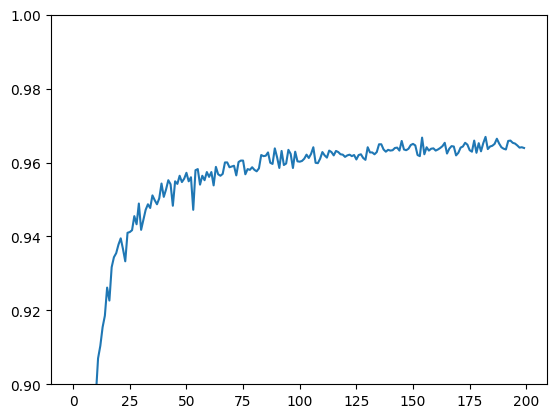

In [9]:
plt.plot(valid_acc)
plt.ylim([0.9,1.0])

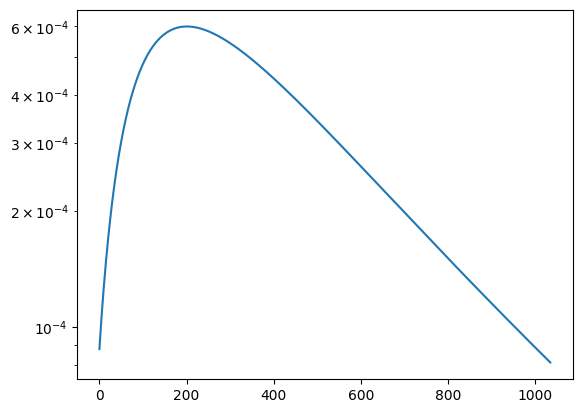

In [10]:
plt.semilogy(learning_rates)